# Импортируем библиотеки

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


import nltk
from nltk.corpus import stopwords

import re

import warnings
warnings.filterwarnings('ignore')

# Загрузка данных

In [2]:
df = pd.read_csv("train.tsv", sep = '\t')
df.info()
df.head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


<bound method NDFrame.head of                                                   title  is_fake
0     Москвичу Владимиру Клутину пришёл счёт за вмеш...        1
1     Агент Кокорина назвал езду по встречке житейск...        0
2     Госдума рассмотрит возможность введения секрет...        1
3     ФАС заблокировала поставку скоростных трамваев...        0
4     Против Навального завели дело о недоносительст...        1
...                                                 ...      ...
5753  Эдди Чемберс получил сотрясение мозга в бою с ...        0
5754  Правительство застроит Россию нефтепродуктопро...        0
5755  «Мне стыдно перед дедом»: новый канцлер ФРГ об...        1
5756   Туркмения в декабре начнет поставки газа в Китай        0
5757  Бывший тренер Локомотива возглавил нальчикский...        0

[5758 rows x 2 columns]>

# Анализ данных

In [3]:
#прверим, есть ли значение null
df.isnull().sum()

title      0
is_fake    0
dtype: int64

Значения типа null отсутствуют, поэтому мы можем использовать всю тренировочную выборку

Проверим, сбалансирована ли наша выборка?

<AxesSubplot:ylabel='Fake or Real'>

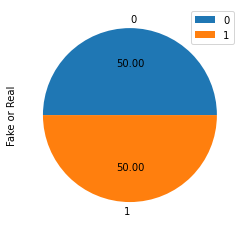

In [4]:
df.groupby('is_fake').size().plot(kind='pie', autopct='%.2f', legend=True, label="Fake or Real")

Наша выборка сбалансирована идеально.

Проверим, есть ли дупликаты в выборке:

In [5]:
print(df.duplicated().sum())

1


Есть одно значение, которое должно быть удалено

In [6]:
df.drop_duplicates(inplace = True)

Обработаем данные, для этого приведем все символы к нижнему регистру и удалим из текста столбца title все знаки пунктуации, различные небуквенные символы и цифры. Соединим оба этих действия в функции.

In [7]:
def drop(text):
    text = text.lower()#приведение всех символов к нижнему регстру
    text = re.sub(r'[^\w\s]',' ',text,flags=re.UNICODE)#удаление небуквенных символов
    return text

In [8]:
#проверим
df["title"] = df["title"].apply(drop)
df.head

<bound method NDFrame.head of                                                   title  is_fake
0     москвичу владимиру клутину пришёл счёт за вмеш...        1
1     агент кокорина назвал езду по встречке житейск...        0
2     госдума рассмотрит возможность введения секрет...        1
3     фас заблокировала поставку скоростных трамваев...        0
4     против навального завели дело о недоносительст...        1
...                                                 ...      ...
5753  эдди чемберс получил сотрясение мозга в бою с ...        0
5754  правительство застроит россию нефтепродуктопро...        0
5755   мне стыдно перед дедом   новый канцлер фрг об...        1
5756   туркмения в декабре начнет поставки газа в китай        0
5757  бывший тренер локомотива возглавил нальчикский...        0

[5757 rows x 2 columns]>

Разделим выборку на X и y, где X - title, y - is_fake. Далее раздлеим их тренировочную и тестовую выборки.

In [9]:
#параметр X - новость
#параметр y - оценка новости (fake - 1; real - 0)
X = df.title
y = df.is_fake

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

Векторизуем данные и удалим стоп-слова. Наш текст на русском, поэтому для русских стоп-слов используем библиотеку nltk. 

In [10]:
#загрузка стоп-слов
nltk.download('stopwords')
stop_words = stopwords.words("russian")
print(stop_words)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Пользователь\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Моделирование

Для модклирования будем использовать 3 модели, для предсказания в тестовой выборке будем использовать модель с наибольшим значением f1 метрики.

## Multionominal Naive Bayes

In [11]:
#создаем модель, используем Pipeline, в котором векторизуем данные и удаляем стоп-слова
model_MNB = Pipeline([
    ('tf-idf',TfidfVectorizer(stop_words=stop_words)),
    ('clf',MultinomialNB())
])

In [12]:
#обучение модели
model_MNB.fit(X_train, y_train) 

Pipeline(steps=[('tf-idf',
                 TfidfVectorizer(stop_words=['и', 'в', 'во', 'не', 'что', 'он',
                                             'на', 'я', 'с', 'со', 'как', 'а',
                                             'то', 'все', 'она', 'так', 'его',
                                             'но', 'да', 'ты', 'к', 'у', 'же',
                                             'вы', 'за', 'бы', 'по', 'только',
                                             'ее', 'мне', ...])),
                ('clf', MultinomialNB())])

In [13]:
#получим предсказания модели и оценим ее с помощью метрики f1_score
pred_MNB = model_MNB.predict(X_valid)
score = f1_score(y_valid, pred_MNB)
print("f1 score for Multinominal naive bayes: ", score)

f1 score for Multinominal naive bayes:  0.8309503784693019


## Decision Tree Classifier

In [14]:
#создаем модель, используем Pipeline, в котором векторизуем данные и удаляем стоп-слова
model_DTC = Pipeline([
    ('tf-idf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', DecisionTreeClassifier())
])

In [15]:
#обучение модели
model_DTC.fit(X_train, y_train)

Pipeline(steps=[('tf-idf',
                 TfidfVectorizer(stop_words=['и', 'в', 'во', 'не', 'что', 'он',
                                             'на', 'я', 'с', 'со', 'как', 'а',
                                             'то', 'все', 'она', 'так', 'его',
                                             'но', 'да', 'ты', 'к', 'у', 'же',
                                             'вы', 'за', 'бы', 'по', 'только',
                                             'ее', 'мне', ...])),
                ('clf', DecisionTreeClassifier())])

In [16]:
#получим предсказания модели и оценим ее с помощью метрики f1_score
pred_DTC = model_DTC.predict(X_valid)
score = f1_score(y_valid, pred_DTC)
print("f1 score for Decision Tree Classifier: ", score)

f1 score for Decision Tree Classifier:  0.6653102746693794


## Random Forest Classifier

In [17]:
#создаем модель, используем Pipeline, в котором векторизуем данные и удаляем стоп-слова
model_RFC = Pipeline([
    ('tf-idf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', RandomForestClassifier(random_state = 0))
])

In [18]:
#обучение модели
model_RFC.fit(X_train, y_train)

Pipeline(steps=[('tf-idf',
                 TfidfVectorizer(stop_words=['и', 'в', 'во', 'не', 'что', 'он',
                                             'на', 'я', 'с', 'со', 'как', 'а',
                                             'то', 'все', 'она', 'так', 'его',
                                             'но', 'да', 'ты', 'к', 'у', 'же',
                                             'вы', 'за', 'бы', 'по', 'только',
                                             'ее', 'мне', ...])),
                ('clf', RandomForestClassifier(random_state=0))])

In [19]:
#получим предсказания модели и оценим ее с помощью метрики f1_score
pred_RFC = model_RFC.predict(X_valid)
score = f1_score(y_valid, pred_RFC)
print("f1 score for Random Forest Classifier: ", score)

f1 score for Random Forest Classifier:  0.6587215601300108


Как мы видим, наибольшая оценка у первой модели Multinominal Naive Bayes. Прэтому для предсказания в тестовых данных будем использовать ее.

# Тестовая задача

Загрузим тестовый набор данных и проведем над ним те же действия для изменения, что и над тренировочным.

In [20]:
df_test = pd.read_csv("test.tsv", sep = '\t')
df_test.info()
df_test.head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1000 non-null   object
 1   is_fake  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


<bound method NDFrame.head of                                                  title  is_fake
0    Роскомнадзор представил реестр сочетаний цвето...        0
1    Ночью под Минском на президентской горе Белара...        0
2    Бывший спичрайтер Юрия Лозы рассказал о трудно...        0
3    Сельская церковь, собравшая рекордно низкое ко...        0
4    Акции Google рухнули после объявления о переза...        0
..                                                 ...      ...
995  Прокуратура заподозрила Явлинского в авторитар...        0
996  В День Победы стратегические ракетоносцы Ту-16...        0
997  СК возбудил дело против авиакомпании «Победа» ...        0
998  Криптомонетный двор Туркменистана выпустил юби...        0
999  Deutsche Bahn заплатит рекордный штраф за чтен...        0

[1000 rows x 2 columns]>

In [21]:
#прверим, есть ли значение null
df_test.isnull().sum()

title      0
is_fake    0
dtype: int64

Сформируем выборку значений X. Используем метод copy, так как если не испольщовать его, то тестовая выборка значений X будет ссылаться на тестовы data frame.

In [22]:
X_test = df_test.title.copy()#значения X - сами новости

Также, как и в тренировочной выборке, уменьшим регистр и удалим лишние символы.

In [23]:
#применение вышеописанной функции
X_test = X_test.apply(drop)
#проверка
X_test[:5]

0    роскомнадзор представил реестр сочетаний цвето...
1    ночью под минском на президентской горе белара...
2    бывший спичрайтер юрия лозы рассказал о трудно...
3    сельская церковь  собравшая рекордно низкое ко...
4    акции google рухнули после объявления о переза...
Name: title, dtype: object

In [24]:
#получаем предсказание модели
y_test = model_MNB.predict(X_test)

In [25]:
#в столбец is_fake устанавливаем значения предсказаний модели
df_test['is_fake'] = y_test

In [26]:
#выведем data frame для проверки
df_test.head

<bound method NDFrame.head of                                                  title  is_fake
0    Роскомнадзор представил реестр сочетаний цвето...        1
1    Ночью под Минском на президентской горе Белара...        1
2    Бывший спичрайтер Юрия Лозы рассказал о трудно...        1
3    Сельская церковь, собравшая рекордно низкое ко...        0
4    Акции Google рухнули после объявления о переза...        0
..                                                 ...      ...
995  Прокуратура заподозрила Явлинского в авторитар...        0
996  В День Победы стратегические ракетоносцы Ту-16...        1
997  СК возбудил дело против авиакомпании «Победа» ...        1
998  Криптомонетный двор Туркменистана выпустил юби...        1
999  Deutsche Bahn заплатит рекордный штраф за чтен...        0

[1000 rows x 2 columns]>

In [27]:
#загружаем файл в ту же директорию, что и данный ноутбук, в последующем создадим python скрипт для перемещения файла
df_test.to_csv("predictions.tsv", sep='\t')